# Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
import os
import geopandas as gpd
from Bio import Entrez
import time
from tqdm import tqdm
import requests
from Bio import Entrez
import gzip
import subprocess 
from scipy.spatial.distance import cdist
from sklearn.preprocessing import LabelEncoder, StandardScaler

In [2]:
rfe_df = pd.read_csv("/home/chandru/binp37/results/metasub/metasub_training_testing_data.csv")
rfe_df.head()

,Acidovorax ebreus,Acidovorax sp. JS42,Acidovorax sp. KKS102,Acinetobacter baumannii,Acinetobacter haemolyticus,Acinetobacter johnsonii,Acinetobacter junii,Acinetobacter pittii,Acinetobacter schindleri,Acinetobacter sp. LoGeW2-3,...,Variovorax boronicumulans,Variovorax paradoxus,Variovorax sp. PAMC 28711,Veillonella parvula,Weissella cibaria,Xanthomonas campestris,continent,city,latitude,longitude
0,0.00000,0.00000,0.00023,0.00015,0.00000,0.00006,0.00001,0.00007,0.00010,0.00005,...,0.00031,0.00075,0.00021,0.0,0.0,0.00480,oceania,hamilton,-37.78333,175.28333
1,0.00000,0.00001,0.00003,0.00028,0.00016,0.00142,0.00017,0.00013,0.00262,0.00140,...,0.00013,0.00024,0.00003,0.0,0.0,0.00091,oceania,hamilton,-37.78333,175.28333
2,0.00003,0.00000,0.00011,0.00181,0.00060,0.00274,0.00030,0.00110,0.00191,0.00132,...,0.00010,0.00025,0.00001,0.0,0.0,0.00208,oceania,hamilton,-37.78333,175.28333
3,0.00000,0.00000,0.00000,0.00002,0.00001,0.00003,0.00000,0.00000,0.00003,0.00001,...,0.00003,0.00002,0.00000,0.0,0.0,0.00137,oceania,hamilton,-37.78333,175.28333
4,0.00000,0.00000,0.00000,0.00003,0.00000,0.00000,0.00000,0.00002,0.00009,0.00001,...,0.00004,0.00008,0.00003,0.0,0.0,0.00397,oceania,hamilton,-37.78333,175.28333


In [3]:
# Data processing function for hierarchical model
def process_data_hierarchical(df):
    """Process data for hierarchical prediction"""
    # Process continuous features
    cont_cols = [col for col in df.columns if col not in [
        'latitude', 'longitude',
        'latitude_rad', 'longitude_rad', 'x', 'y', 'z',
        'scaled_x', 'scaled_y', 'scaled_z', 'continent', 'city'
    ]]
    
    # Get the features
    x_cont = df[cont_cols].values
    
    # Encode continent labels
    continent_encoder = LabelEncoder()
    y_continent = continent_encoder.fit_transform(df['continent'].values)
    
    # Encode city labels
    city_encoder = LabelEncoder()
    y_city = city_encoder.fit_transform(df['city'].values)
    
    # Calculate coordinates if not already present
    if not all(col in df.columns for col in ['x', 'y', 'z']):
        df['latitude_rad'] = np.deg2rad(df['latitude'])
        df['longitude_rad'] = np.deg2rad(df['longitude'])
        df['x'] = np.cos(df['latitude_rad']) * np.cos(df['longitude_rad'])
        df['y'] = np.cos(df['latitude_rad']) * np.sin(df['longitude_rad'])
        df['z'] = np.sin(df['latitude_rad'])
    
    # Scale coordinates
    coord_scaler = StandardScaler()
    y_coords = coord_scaler.fit_transform(df[['x', 'y', 'z']].values)
    
    continents = continent_encoder.classes_
    cities = city_encoder.classes_
    
    print(f"Continents: {len(continents)} ({continents})")
    print(f"Cities: {len(cities)}")
    print(f"Continuous features: {len(cont_cols)}")
    
    return {
        'x_cont': x_cont,
        'y_continent': y_continent,
        'y_city': y_city,
        'y_coords': y_coords, # This is for neural networks. Scaling is required
        'y_latitude': df['latitude'].values, # This is for XGBoost, we don't need to scale this
        'y_longitude':df['longitude'].values, # This is for XGBoost, we don't need to scale this
        'encoders': {
            'continent': continent_encoder,
            'city': city_encoder,
            'coord': coord_scaler
        },
        'continents': continents,
        'cities': cities
    }

df = pd.read_csv("/home/chandru/binp37/results/metasub/metasub_training_testing_data.csv")
processed_data = process_data_hierarchical(df)

Continents: 7 (['east_asia' 'europe' 'middle_east' 'north_america' 'oceania'
 'south_america' 'sub_saharan_africa'])
Cities: 40
Continuous features: 200


In [4]:
os.chdir("/home/chandru/binp37/scripts/ensemble")
y_test_cont = np.load("saved_results/y_test_cont.npy")
y_pred_cont = np.load("saved_results/y_pred_cont.npy")

y_test_city = np.load("saved_results/y_test_city.npy")
y_pred_city = np.load("saved_results/y_pred_city.npy")

y_test_coords = np.load("saved_results/y_test_coord.npy")
y_pred_coords = np.load("saved_results/y_pred_coord.npy")


In [5]:
df = pd.DataFrame({
    'true_cont': y_test_cont,
    'pred_cont': y_pred_cont,
    'true_city': y_test_city,
    'pred_city': y_pred_city,
    'true_lat': y_test_coords[:, 0],
    'true_lon': y_test_coords[:, 1],
    'pred_lat': y_pred_coords[:, 0],
    'pred_lon': y_pred_coords[:, 1]
})

In [6]:
continents = np.array([
    'east_asia', 'europe', 'middle_east', 'north_america',
    'oceania', 'south_america', 'sub_saharan_africa'
])

cities = np.array([
    'auckland', 'baltimore', 'barcelona', 'berlin', 'bogota', 'brisbane',
    'denver', 'doha', 'europe', 'fairbanks', 'hamilton', 'hanoi',
    'hong_kong', 'ilorin', 'kuala_lumpur', 'kyiv', 'lisbon', 'london',
    'marseille', 'minneapolis', 'naples', 'new_york_city', 'offa', 'oslo',
    'paris', 'rio_de_janeiro', 'sacramento', 'san_francisco', 'santiago',
    'sao_paulo', 'sendai', 'seoul', 'singapore', 'sofia', 'stockholm',
    'taipei', 'tokyo', 'vienna', 'yamaguchi', 'zurich'
])


In [7]:
df['true_cont_name'] = df['true_cont'].map(lambda i: continents[i])
df['pred_cont_name'] = df['pred_cont'].map(lambda i: continents[i])

df['true_city_name'] = df['true_city'].map(lambda i: cities[i])
df['pred_city_name'] = df['pred_city'].map(lambda i: cities[i])

cont_support_map = dict(zip(np.unique(df['true_cont_name'],return_counts=True)[0],np.unique(df['true_cont_name'],return_counts=True)[1]))
city_support_map = dict(zip(np.unique(df['true_city_name'],return_counts=True)[0],np.unique(df['true_city_name'],return_counts=True)[1]))

In [8]:
# Step 1: Compute the correctness 
df['continent_correct'] = df['true_cont'] == df['pred_cont']
df['city_correct'] = df['true_city'] == df['pred_city']

# Step 2: Compute coordinates distance

# Distance between two points on the earth
def haversine_distance(lat1,lon1,lat2,lon2):
    """
    Calculate the great circle distance between two points on the earth
    """
    # Radius of the earth
    R = 6371.0

    # Convert from degrees to radians
    lat1_rad = np.radians(lat1)
    lon1_rad = np.radians(lon1)
    lat2_rad = np.radians(lat2)
    lon2_rad = np.radians(lon2)

    dlat = lat2_rad - lat1_rad
    dlon = lon2_rad - lon1_rad

    a = np.sin(dlat/2)**2 + np.cos(lat1_rad) * np.cos(lat2_rad) * np.sin(dlon/2) **2
    c = 2 * np.arcsin(np.sqrt(a))

    return R * c # in kilometers


df['coord_error'] = haversine_distance(df['true_lat'].values,df['true_lon'].values,df['pred_lat'].values,df['pred_lon'].values)

In [9]:
print(f'The median distance error is {np.median(df['coord_error'].values)}')
print(f'The mean distance error is {np.mean(df['coord_error'].values)}')
print(f'The max distance error is {np.max(df['coord_error'].values)}')

The median distance error is 20.07653045654297
The mean distance error is 734.4038696289062
The max distance error is 15103.9716796875


In [11]:
# Sort the DataFrame by 'coord_error' in descending order
df_sorted = df.sort_values(by='coord_error', ascending=False)   
print("Top 10 largest coordinate errors:")
df_sorted[['true_city_name', 'pred_city_name', 'true_cont_name', 'pred_cont_name','true_lat','pred_lat','true_lon','pred_lon',
            'coord_error']].head(10)

Top 10 largest coordinate errors:


,true_city_name,pred_city_name,true_cont_name,pred_cont_name,true_lat,pred_lat,true_lon,pred_lon,coord_error
86,sao_paulo,sao_paulo,south_america,east_asia,-23.561726,14.896492,-46.656693,87.272217,15103.971680
703,brisbane,sao_paulo,oceania,europe,-27.420399,-22.029778,152.992477,-30.461449,14503.957031
208,singapore,sao_paulo,east_asia,europe,1.298330,-11.233365,103.798027,-19.966652,13713.282227
111,hanoi,ilorin,east_asia,sub_saharan_africa,21.000000,29.322142,105.000000,-25.906933,12336.811523
159,hanoi,ilorin,east_asia,sub_saharan_africa,21.000000,36.146423,105.000000,-9.883223,10683.022461
42,san_francisco,san_francisco,north_america,north_america,37.766602,37.919083,122.448097,-115.454239,9720.694336
533,zurich,singapore,europe,east_asia,47.000000,2.901760,8.000000,95.988693,9619.123047
44,zurich,fairbanks,europe,north_america,47.000000,41.875515,8.000000,-136.358429,9526.075195
542,tokyo,minneapolis,east_asia,north_america,35.640141,44.312656,139.631577,-96.526382,9476.824219
667,lisbon,fairbanks,europe,north_america,38.753819,47.899376,-9.230830,-137.743027,9119.770508


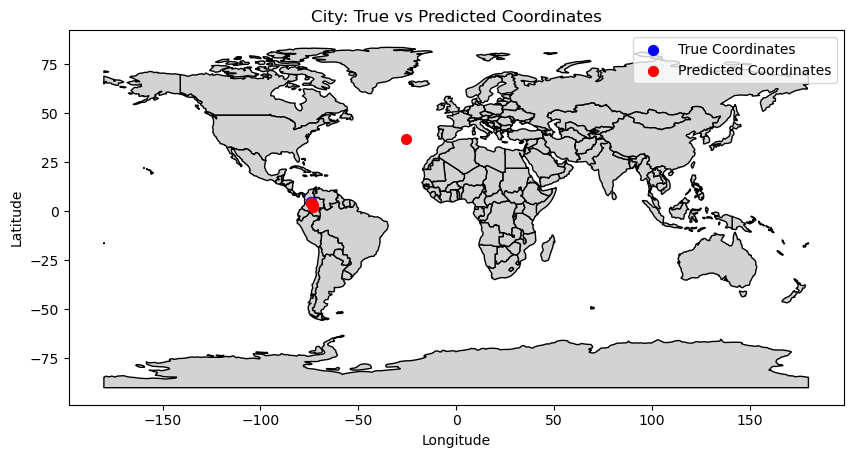

In [44]:
world = gpd.read_file("/home/chandru/binp37/data/geopandas/ne_110m_admin_0_countries.shp")

plot_city = df_sorted[df_sorted['true_city_name'] == 'bogota']

# Plot the map
fig, ax = plt.subplots(figsize=(10, 10))
world.plot(ax=ax, color='lightgrey', edgecolor='black')  # Plot the world map
ax.scatter(plot_city['true_lon'], plot_city['true_lat'], color='blue', label='True Coordinates', s=50)
ax.scatter(plot_city['pred_lon'], plot_city['pred_lat'], color='red', label='Predicted Coordinates', s=50)
ax.set_title('City: True vs Predicted Coordinates')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.legend()
plt.show()

In [45]:
plot_city

,true_cont,pred_cont,true_city,pred_city,true_lat,true_lon,pred_lat,pred_lon,true_cont_name,pred_cont_name,true_city_name,pred_city_name,continent_correct,city_correct,coord_error
177,5,3,4,9,4.709295,-74.110184,36.749287,-25.641098,south_america,north_america,bogota,fairbanks,False,False,6076.692383
486,5,5,4,4,4.709295,-74.110184,2.013219,-73.124214,south_america,south_america,bogota,bogota,True,True,319.139740
174,5,5,4,4,4.658168,-74.062149,3.219777,-73.347282,south_america,south_america,bogota,bogota,True,True,178.520950
481,5,5,4,4,4.657462,-74.062187,4.408262,-74.300613,south_america,south_america,bogota,bogota,True,True,38.292641


/home/chandru/.conda/envs/binp37_env/lib/python3.13/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/chandru/.conda/envs/binp37_env/lib/python3.13/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/chandru/.conda/envs/binp37_env/lib/python3.13/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/chandru/.conda/envs/binp37_env/lib/python3.13/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is de

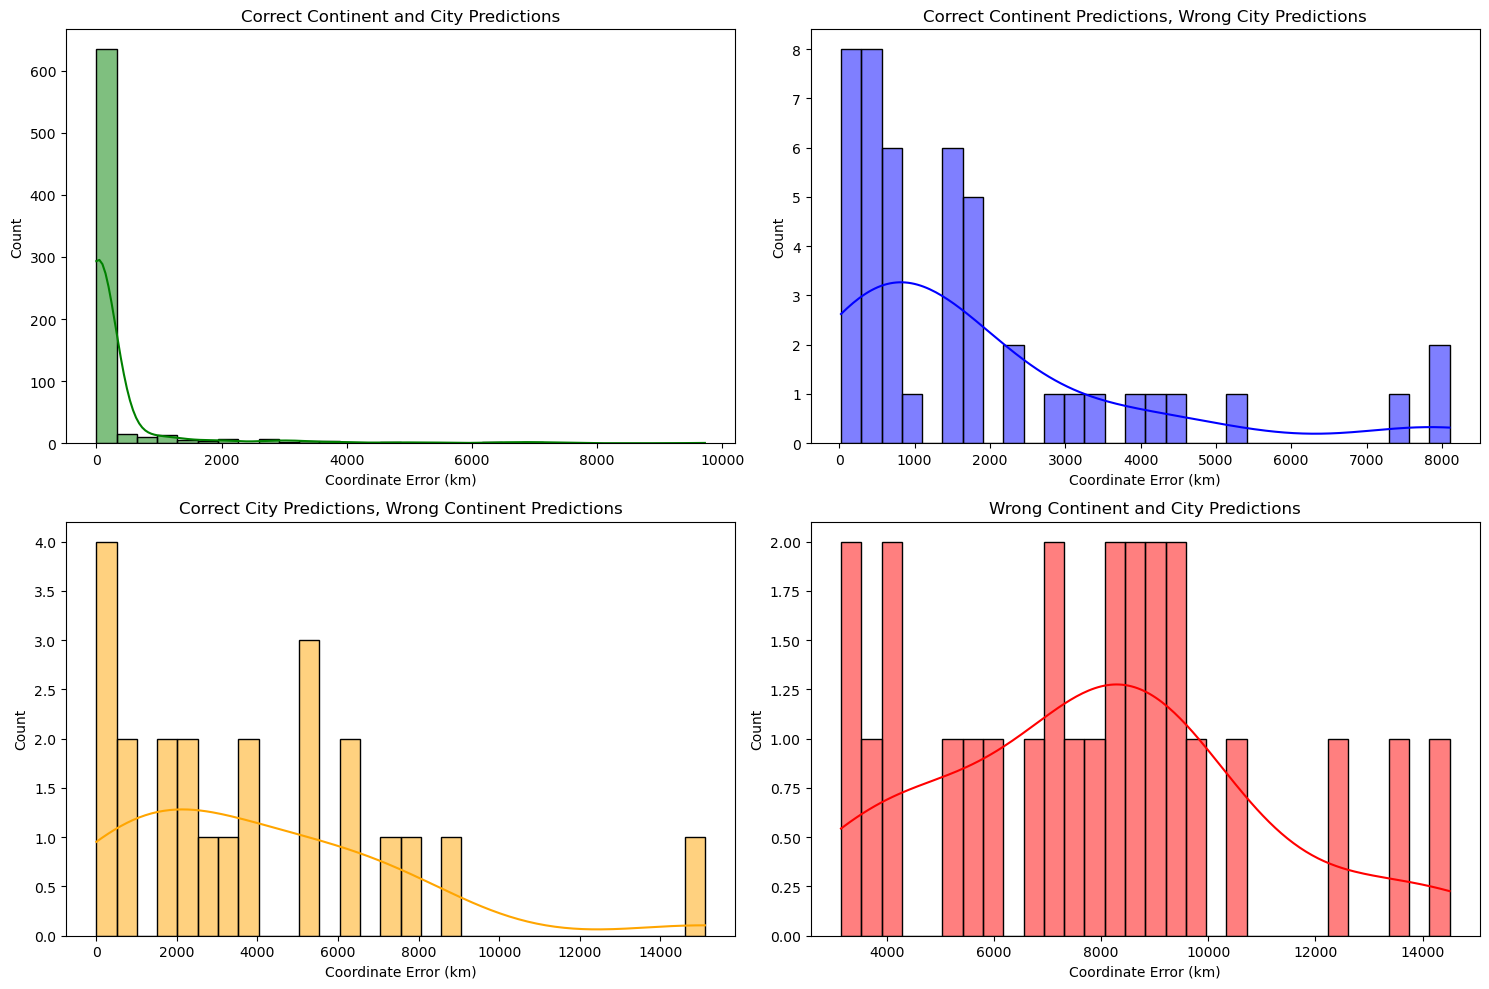

In [13]:
# Get the dataset that has correct continent and city predictions and sort the coord error from high to low
correct_df = df[(df['continent_correct']) & (df['city_correct'])]
correct_df = correct_df.sort_values(by='coord_error', ascending=False)
# Get the dataset that has correct contient by wrong city predictions and sort the coord error from high to low
correct_cont_df = df[(df['continent_correct']) & (~df['city_correct'])]
correct_cont_df = correct_cont_df.sort_values(by='coord_error', ascending=False)
# Get the dataset that has correct city by wrong continent predictions and sort the coord error from high to low
correct_city_df = df[(~df['continent_correct']) & (df['city_correct'])]
correct_city_df = correct_city_df.sort_values(by='coord_error', ascending=False)
# Get the dataset that has wrong continent and city predictions and sort the coord error from high to low
wrong_df = df[(~df['continent_correct']) & (~df['city_correct'])]
wrong_df = wrong_df.sort_values(by='coord_error', ascending=False)

# Distribution of coordinate errors for each category
plt.figure(figsize=(15, 10))
plt.subplot(2, 2, 1)
sns.histplot(correct_df['coord_error'], bins=30, kde=True, color='green')
plt.title('Correct Continent and City Predictions')
plt.xlabel('Coordinate Error (km)') 
plt.subplot(2, 2, 2)
sns.histplot(correct_cont_df['coord_error'], bins=30, kde=True, color='blue')
plt.title('Correct Continent Predictions, Wrong City Predictions')
plt.xlabel('Coordinate Error (km)')
plt.subplot(2, 2, 3)
sns.histplot(correct_city_df['coord_error'], bins=30, kde=True, color='orange')
plt.title('Correct City Predictions, Wrong Continent Predictions')
plt.xlabel('Coordinate Error (km)')
plt.subplot(2, 2, 4)
sns.histplot(wrong_df['coord_error'], bins=30, kde=True, color='red')
plt.title('Wrong Continent and City Predictions')
plt.xlabel('Coordinate Error (km)')
plt.tight_layout()
plt.show()


In [14]:
# Get ROC AUC for continent and city - This a multiclass classification problem
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.preprocessing import label_binarize
from sklearn.metrics import precision_recall_curve, auc
# Binarize the true labels for ROC AUC calculation
y_true_cont_binarized = label_binarize(y_test_cont, classes=np.arange(len(processed_data['continents'])))
y_true_city_binarized = label_binarize(y_test_city, classes=np.arange(len(processed_data['cities'])))

# Calculate ROC AUC for continent and city
roc_auc_continent = roc_auc_score(y_true_cont_binarized, label_binarize(y_pred_cont, classes=np.arange(len(processed_data['continents']))), average='macro', multi_class='ovr')
roc_auc_city = roc_auc_score(y_true_city_binarized, label_binarize(y_pred_city, classes=np.arange(len(processed_data['cities']))), average='macro', multi_class='ovr')

# Calculate Precision-Recall AUC for continent and city
precision_cont, recall_cont, _ = precision_recall_curve(y_true_cont_binarized.ravel(), label_binarize(y_pred_cont, classes=np.arange(len(processed_data['continents']))).ravel())
prc_auc_continent = auc(recall_cont, precision_cont)

precision_city, recall_city, _ = precision_recall_curve(y_true_city_binarized.ravel(), label_binarize(y_pred_city, classes=np.arange(len(processed_data['cities']))).ravel())
prc_auc_city = auc(recall_city, precision_city)

print(f"ROC AUC (Continent): {roc_auc_continent:.3f}")
print(f"ROC AUC (City): {roc_auc_city:.3f}")
print(f"PRC AUC (Continent): {prc_auc_continent:.3f}")
print(f"PRC AUC (City): {prc_auc_city:.3f}")


ROC AUC (Continent): 0.933
ROC AUC (City): 0.895
PRC AUC (Continent): 0.944
PRC AUC (City): 0.913


In [15]:
# Step 3: Group into the 4 categories
def group_label(row):
    if row['continent_correct'] and row['city_correct']:
        return 'C_correct Z_correct'
    elif row['continent_correct'] and not row['city_correct']:
        return 'C_correct Z_wrong'
    elif not row['continent_correct'] and row['city_correct']:
        return 'C_wrong Z_correct'
    else:
        return 'C_wrong Z_wrong'

df['error_group'] = df.apply(group_label, axis=1)

In [16]:
# Step 4: Aggregate stats
group_stats = df.groupby('error_group')['coord_error'].agg([
    ('count', 'count'),
    ('mean_error_km', 'mean'),
    ('median_error_km', 'median')
])

In [17]:
# Step 5: Calculate proportions and expected error
total = len(df)
group_stats['proportion'] = group_stats['count'] / total
group_stats['weighted_error'] = group_stats['mean_error_km'] * group_stats['proportion']
expected_total_error = group_stats['weighted_error'].sum()
print(f"\nExpected Coordinate Error E[D]: {expected_total_error:.2f} km")


Expected Coordinate Error E[D]: 734.40 km


In [18]:
def compute_in_radius_metrics(y_true, y_pred, thresholds=[1, 5, 50, 100, 250, 500, 1000, 5000]):
    """
    Compute % of predictions within given distance thresholds
    y_true, y_pred: numpy arrays of shape (N, 2) for [lat, lon]
    """
    distances = haversine_distance(
        y_true[:, 0], y_true[:, 1], y_pred[:, 0], y_pred[:, 1]
    )

    results = {}
    for r in thresholds:
        percent = np.mean(distances <= r) * 100
        results[f"<{r} km"] = percent
    
    return results, distances

metrics, dists = compute_in_radius_metrics(y_test_coords, y_pred_coords)

print("In-Radius Accuracy Metrics:")
for k, v in metrics.items():
    print(f"{k:>8}: {v:.2f}%")


In-Radius Accuracy Metrics:
   <1 km: 0.98%
   <5 km: 16.71%
  <50 km: 63.14%
 <100 km: 70.27%
 <250 km: 77.89%
 <500 km: 80.96%
<1000 km: 84.64%
<5000 km: 94.47%


In [19]:
def in_radius_by_group(df, group_col, thresholds=[1, 5, 50, 100, 250, 500, 1000, 5000]):
    """
    Compute in-radius accuracy for a group column (continent, city, or continent+city)
    """
    df = df.copy()
    df['coord_error'] = haversine_distance(
        df['true_lat'].values, df['true_lon'].values,
        df['pred_lat'].values, df['pred_lon'].values
    )

    results = {}
    grouped = df.groupby(group_col)
    
    for group_name, group_df in grouped:
        res = {}
        errors = group_df['coord_error'].values
        for r in thresholds:
            res[f"<{r} km"] = np.mean(errors <= r) * 100  # in %
        results[group_name] = res
    
    return pd.DataFrame(results).T  # Transpose for better readability


In [20]:
continent_metrics = in_radius_by_group(df, group_col='true_cont_name')
print("In-Radius Accuracy per Continent")
continent_metrics['continent_support'] = continent_metrics.index.map(cont_support_map)
continent_metrics.round(2)

In-Radius Accuracy per Continent


,<1 km,<5 km,<50 km,<100 km,<250 km,<500 km,<1000 km,<5000 km,continent_support
east_asia,0.36,19.06,72.66,75.90,78.42,80.58,83.45,92.81,278
europe,2.12,19.79,55.48,66.78,77.03,82.33,87.28,96.11,283
middle_east,0.00,0.00,40.00,40.00,86.67,86.67,93.33,100.00,15
north_america,0.67,1.34,61.07,67.79,75.17,76.51,81.21,95.30,149
oceania,0.00,0.00,11.11,22.22,44.44,44.44,44.44,55.56,9
south_america,0.00,0.00,47.62,57.14,61.90,71.43,71.43,85.71,21
sub_saharan_africa,0.00,42.37,79.66,86.44,94.92,94.92,94.92,100.00,59


In [21]:
city_metrics = in_radius_by_group(df, group_col='true_city_name')
print("In-Radius Accuracy per City")
city_metrics['city_support'] = city_metrics.index.map(city_support_map)
city_metrics.round(2)

In-Radius Accuracy per City


,<1 km,<5 km,<50 km,<100 km,<250 km,<500 km,<1000 km,<5000 km,city_support
auckland,0.00,0.00,0.00,100.00,100.00,100.00,100.00,100.00,1
baltimore,0.00,0.00,0.00,0.00,0.00,0.00,0.00,100.00,1
barcelona,0.00,0.00,69.57,100.00,100.00,100.00,100.00,100.00,23
berlin,0.00,0.00,26.67,66.67,93.33,93.33,100.00,100.00,15
bogota,0.00,0.00,25.00,25.00,50.00,75.00,75.00,75.00,4
brisbane,0.00,0.00,0.00,0.00,0.00,0.00,0.00,20.00,5
denver,0.00,0.00,40.00,80.00,93.33,100.00,100.00,100.00,15
doha,0.00,0.00,40.00,40.00,86.67,86.67,93.33,100.00,15
europe,0.00,50.00,75.00,75.00,91.67,100.00,100.00,100.00,12
fairbanks,0.00,0.00,42.86,42.86,47.62,47.62,71.43,85.71,21


In [22]:
df['continent_city'] = df['true_cont_name'] + " / " + df['true_city_name']
cont_city_metrics = in_radius_by_group(df, group_col='continent_city')
cont_city_metrics['continent_support'] = cont_city_metrics.index.map(lambda x :x.split("/")[-1].strip()).map(city_support_map)
print("In-Radius Accuracy per Continent-City")
cont_city_metrics.round(2)

In-Radius Accuracy per Continent-City


,<1 km,<5 km,<50 km,<100 km,<250 km,<500 km,<1000 km,<5000 km,continent_support
east_asia / hanoi,0.00,0.00,0.00,0.00,0.00,20.00,40.00,60.00,5
east_asia / hong_kong,0.68,33.11,93.92,93.92,94.59,94.59,94.59,96.62,148
east_asia / kuala_lumpur,0.00,0.00,10.00,80.00,90.00,100.00,100.00,100.00,10
east_asia / sendai,0.00,0.00,25.00,50.00,75.00,100.00,100.00,100.00,4
east_asia / seoul,0.00,21.05,78.95,78.95,84.21,89.47,100.00,100.00,19
east_asia / singapore,0.00,0.00,0.00,0.00,3.12,6.25,12.50,75.00,32
east_asia / taipei,0.00,0.00,89.47,89.47,89.47,94.74,94.74,100.00,19
east_asia / tokyo,0.00,0.00,76.32,78.95,84.21,84.21,84.21,86.84,38
east_asia / yamaguchi,0.00,0.00,0.00,0.00,0.00,0.00,100.00,100.00,3
europe / barcelona,0.00,0.00,69.57,100.00,100.00,100.00,100.00,100.00,23


In [ ]:
# Compute the median, mean and max distance error when both continent and city are correct
df_correct = df[(df['continent_correct']) & (df['city_correct'])]
print(f'The number of samples when both continent and city are correct is {len(df_correct)}')
print(f'The median distance error when both continent and city are correct is {np.median(df_correct['coord_error'].values)}')
print(f'The mean distance error when both continent and city are correct is {np.mean(df_correct['coord_error'].values)}\n')

# Compute the median, mean and max distance error when continent is correct but city is wrong
df_continent_correct = df[(df['continent_correct']) & (~df['city_correct'])]
print(f'The number of samples when continent is correct but city is wrong is {len(df_continent_correct)}')
print(f'The median distance error when continent is correct but city is wrong is {np.median(df_continent_correct['coord_error'].values)}')
print(f'The mean distance error when continent is correct but city is wrong is {np.mean(df_continent_correct['coord_error'].values)}\n')

# Compute the median, mean and max distance error when continent is wrong but city is correct
df_city_correct = df[(~df['continent_correct']) & (df['city_correct'])]
print(f'The number of samples when continent is wrong but city is correct is {len(df_city_correct)}')
print(f'The median distance error when continent is wrong but city is correct is {np.median(df_city_correct['coord_error'].values)}')
print(f'The mean distance error when continent is wrong but city is correct is {np.mean(df_city_correct['coord_error'].values)}\n')   

# Compute the median, mean and max distance error when both continent and city are wrong
df_wrong = df[(~df['continent_correct']) & (~df['city_correct'])]
print(f'The number of samples when both continent and city are wrong is {len(df_wrong)}')
print(f'The median distance error when both continent and city are wrong is {np.median(df_wrong['coord_error'].values)}')
print(f'The mean distance error when both continent and city are wrong is {np.mean(df_wrong['coord_error'].values)}')


The number of samples when both continent and city are correct is 719
The median distance error when both continent and city are correct is 14.558629035949707
The mean distance error when both continent and city are correct is 304.9372863769531

The number of samples when continent is correct but city is wrong is 46
The median distance error when continent is correct but city is wrong is 1132.495361328125
The mean distance error when continent is correct but city is wrong is 1801.8720703125

The number of samples when continent is wrong but city is correct is 23
The median distance error when continent is wrong but city is correct is 3192.7724609375
The mean distance error when continent is wrong but city is correct is 3977.714599609375

The number of samples when both continent and city are wrong is 26
The median distance error when both continent and city are wrong is 8084.8828125
The mean distance error when both continent and city are wrong is 7853.126953125


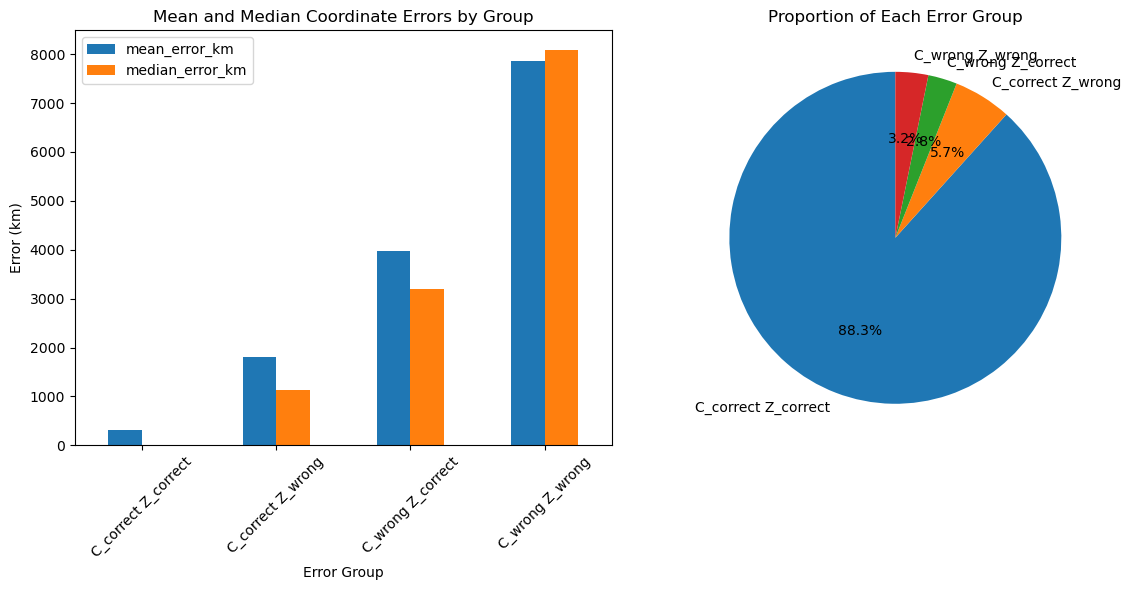

In [23]:
# Plotting group_stats for better visualization
plt.figure(figsize=(12, 6))

# Bar plot for mean and median errors
plt.subplot(1, 2, 1)
group_stats[['mean_error_km', 'median_error_km']].plot(kind='bar', ax=plt.gca())
plt.title('Mean and Median Coordinate Errors by Group')
plt.ylabel('Error (km)')
plt.xlabel('Error Group')
plt.xticks(rotation=45)

# Pie chart for proportions
plt.subplot(1, 2, 2)
group_stats['proportion'].plot(kind='pie', autopct='%1.1f%%', startangle=90, ax=plt.gca())
plt.title('Proportion of Each Error Group')
plt.ylabel('')

plt.tight_layout()
plt.show()

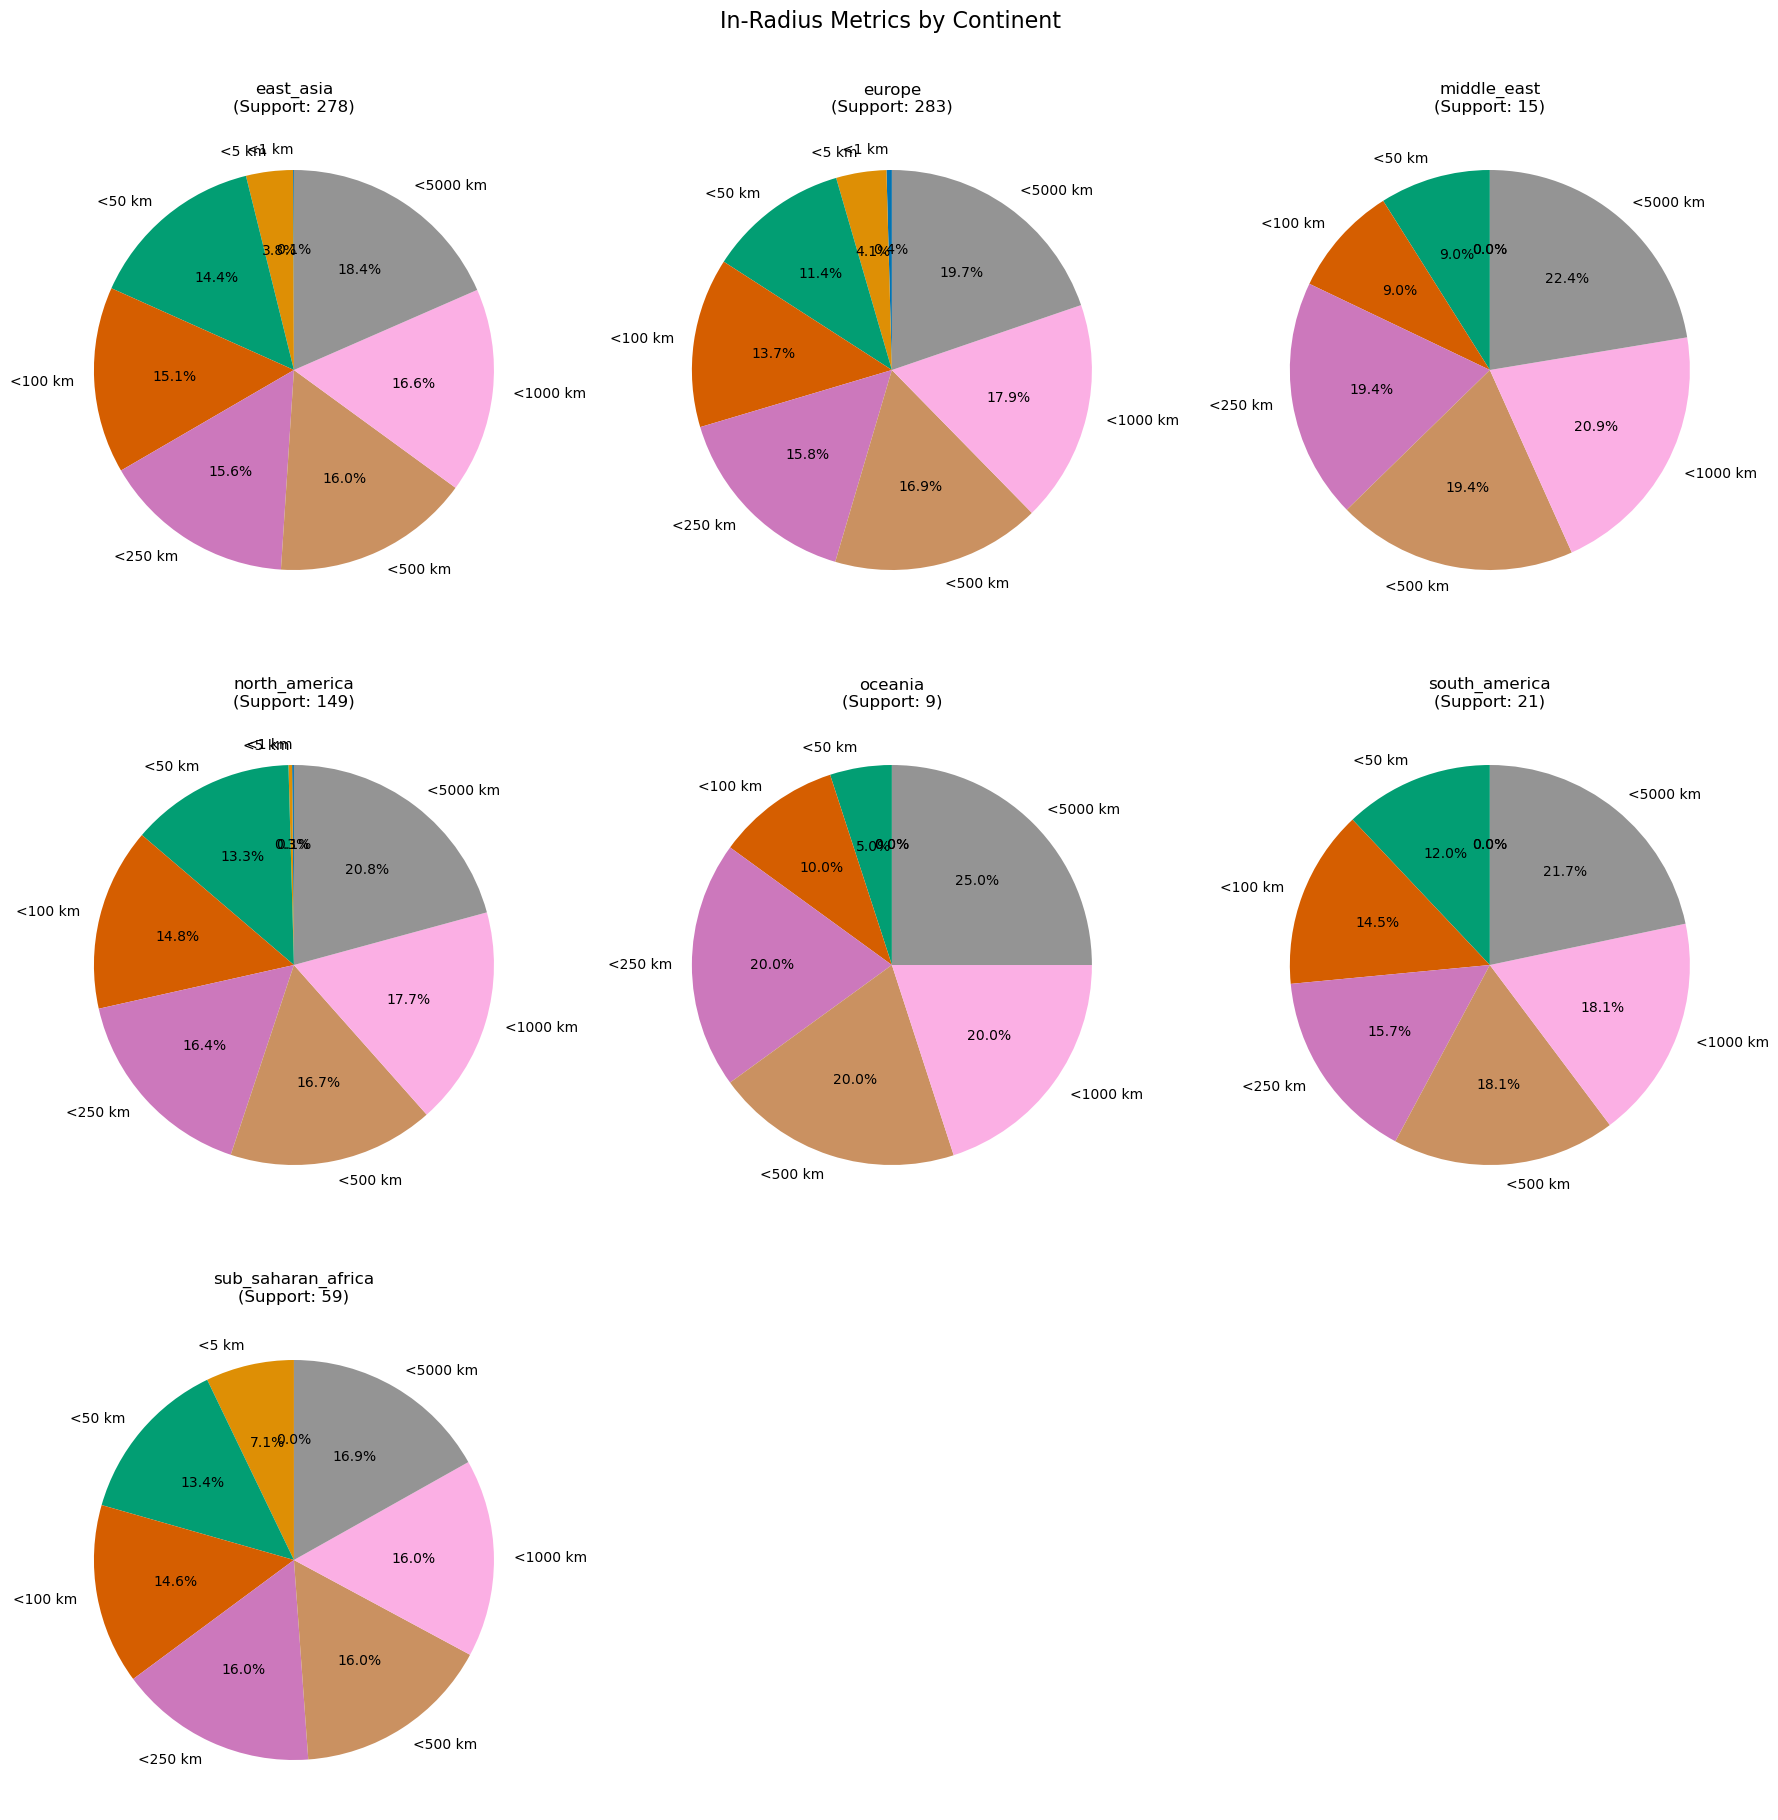

In [24]:
# Plotting in-radius metrics for continents - Pie chart for each continent in subplots
# Create a pie chart for each continent's in-radius metrics
fig, axes = plt.subplots(3, 3, figsize=(18, 18))
axes = axes.flatten()

for i, (continent, row) in enumerate(continent_metrics.iterrows()):
    ax = axes[i]
    row[:-1].plot(
        kind='pie', 
        autopct='%1.1f%%', 
        startangle=90, 
        ax=ax, 
        colors=sns.color_palette("colorblind")
    )
    ax.set_title(f"{continent}\n(Support: {int(row['continent_support'])})", fontsize=12)
    ax.set_ylabel('')

# Remove unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.suptitle("In-Radius Metrics by Continent", fontsize=16, y=1.02)
plt.show()



<Figure size 1400x800 with 0 Axes>

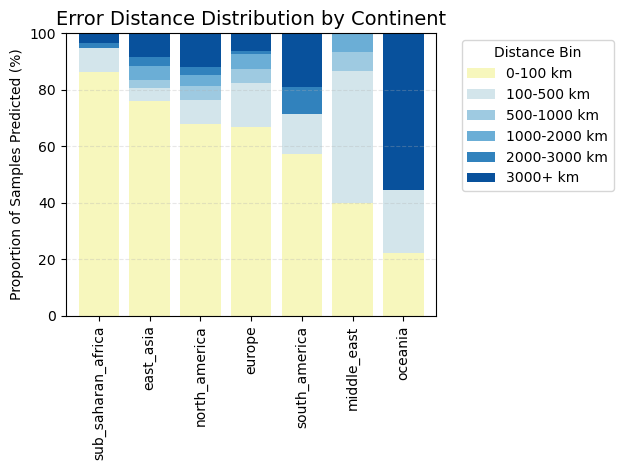

In [ ]:
def error_distribution_by_group(df, group_col, bins=[0, 100, 500, 1000, 2000, 3000, float('inf')]):
    """
    Compute error distribution across distance bins by group
    """
    df = df.copy()
    # Create bin labels
    bin_labels = [
        '0_100', '100_500', '500_1000', 
        '1000_2000', '2000_3000', '3000plus'
    ]
    
    # Bin the errors
    df['error_bin'] = pd.cut(
        df['coord_error'], 
        bins=bins, 
        labels=bin_labels, 
        right=True
    )
    
    # Calculate distribution for each group
    result = pd.crosstab(
        index=df[group_col],
        columns=df['error_bin'],
        normalize='index'
    ) * 100
    
    # Ensure all bins are present
    for bin_name in bin_labels:
        if bin_name not in result.columns:
            result[bin_name] = 0
            
    # Sort columns to ensure correct stacking order
    return result[bin_labels]

# Calculate error distribution by continent
error_dist = error_distribution_by_group(df, 'true_cont_name')

# Sort rows by accuracy (optional)
# This sorts continents by the percentage of samples in the 0-100km bin
error_dist = error_dist.sort_values(by='0_100', ascending=False)

# Create the stacked bar chart
plt.figure(figsize=(14, 8))

# Define color palette - light to dark
colors = ['#f7f7bd', '#d3e5eb', '#9ecae1', '#6baed6', '#3182bd', '#08519c']

# Plot with the specified colors
error_dist.plot(kind='bar', stacked=True, color=colors, width=0.8)

# Add labels and title
plt.xlabel('')
plt.ylabel('Proportion of Samples Predicted (%)')
plt.title('Error Distance Distribution by Continent', fontsize=14)
plt.ylim(0, 100)

# Add legend with distance bin labels
legend_labels = ['0-100 km', '100-500 km', '500-1000 km', 
                 '1000-2000 km', '2000-3000 km', '3000+ km']
plt.legend(title='Distance Bin', labels=legend_labels, bbox_to_anchor=(1.05, 1), loc='upper left')

# Customize grid for better readability
plt.grid(axis='y', linestyle='--', alpha=0.3)

plt.tight_layout()
plt.show()

<Figure size 1400x800 with 0 Axes>

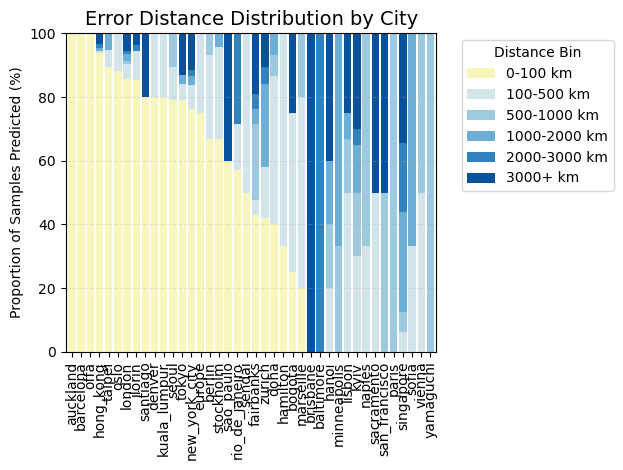

In [26]:
# For city-level analysis
city_error_dist = error_distribution_by_group(df, 'true_city_name')

# Optional: Keep only top N cities with most samples
# top_cities = df['true_city_name'].value_counts().nlargest(20).index
# city_error_dist = city_error_dist.loc[top_cities]

# Sort cities by accuracy (smallest error percentage first)
city_error_dist = city_error_dist.sort_values(by='0_100', ascending=False)

# Create the stacked bar chart for cities
plt.figure(figsize=(14, 8))
city_error_dist.plot(kind='bar', stacked=True, color=colors, width=0.8) 
plt.xlabel('')
plt.ylabel('Proportion of Samples Predicted (%)')
plt.title('Error Distance Distribution by City', fontsize=14)
plt.ylim(0, 100)
plt.legend(title='Distance Bin', labels=legend_labels, bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

